Projenin amacı: Şarkıların eurovision’da ilk 10’a girip girmediğini tahmin etmek

Hedef değişken: Top10 (1: ilk 10’da, 0: değil)

## Veri Ön İşleme

In [3]:
import numpy as np
import pandas as pd

# verilerin bulunduğu csv dosyasını dataframe'e okuma
df_main = pd.read_csv("song_data.csv", encoding="windows-1252")


# dataframe genel bilgilerini görüntüleme
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   565 non-null    int64  
 1   semi_final             565 non-null    object 
 2   semi_draw_position     565 non-null    object 
 3   final_draw_position    554 non-null    object 
 4   country                565 non-null    object 
 5   artist_name            565 non-null    object 
 6   song_name              565 non-null    object 
 7   language               565 non-null    object 
 8   style                  565 non-null    object 
 9   direct_qualifier_10    565 non-null    object 
 10  gender                 565 non-null    object 
 11  main_singers           565 non-null    int64  
 12  age                    565 non-null    object 
 13  selection              565 non-null    object 
 14  key                    565 non-null    object 
 15  BPM   

In [4]:
# hedef değişkenimiz top 10 olduğundan final sıralaması ilk 10 olanları değişkenine ekleme
df_main["top10"] = df_main["final_place"].apply(lambda x: 1 if x <= 10 else 0)

# fayda sağlayacak sütunları ayıklama
selected_columns = [
    "year",
    "country",
    "semi_draw_position",
    "final_draw_position",
    "BPM",
    "energy",
    "danceability",
    "happiness",
    "acousticness",
    "liveness",
    "speechiness",
    "style",
    "language",
    "key",
    "direct_qualifier_10",
    "qualified_10",
    "top10"
]

df = df_main[selected_columns].copy()

# dataframe'deki eksik değer kontrolü
missing_values_model = df.isnull().sum()
print(missing_values_model[missing_values_model > 0].sort_values(ascending=False))


final_draw_position    11
dtype: int64


In [5]:
# final sıralaması eksik olan değerleri - ile doldurma (finale çıkamayan şarkıların değerleri eksik)

df["final_draw_position"] = df["final_draw_position"].fillna("-")

In [6]:
# verilerin makine öğrenmesi algoritma kullanımına hazırlanması

# kategorik sütunların belirlenmesi
categorical_columns = df.select_dtypes(include="object").columns.tolist()

from sklearn.preprocessing import LabelEncoder

# NaN değerleri doldurma (örneğin, boş değerleri 'Unknown' ile doldurabiliriz)
for col in categorical_columns:
    df[col] = df[col].fillna('Unknown')

# label encoding uygulanması
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# ilk 5 satırı görüntüleme
df.head()


,year,country,semi_draw_position,final_draw_position,BPM,energy,danceability,happiness,acousticness,liveness,speechiness,style,language,key,direct_qualifier_10,qualified_10,top10
0,2023,32,1,13,11,17,46,14,51,1,15,3,13,18,1,2,1
1,2023,27,12,0,4,58,52,76,13,9,18,3,13,22,0,1,0
2,2023,38,13,23,4,50,38,2,34,25,21,3,66,1,1,2,0
3,2023,25,14,0,56,35,38,32,44,53,23,4,13,2,0,1,0
4,2023,34,15,12,46,43,48,70,26,7,21,3,59,24,1,2,0


## Veri Ölçekleme

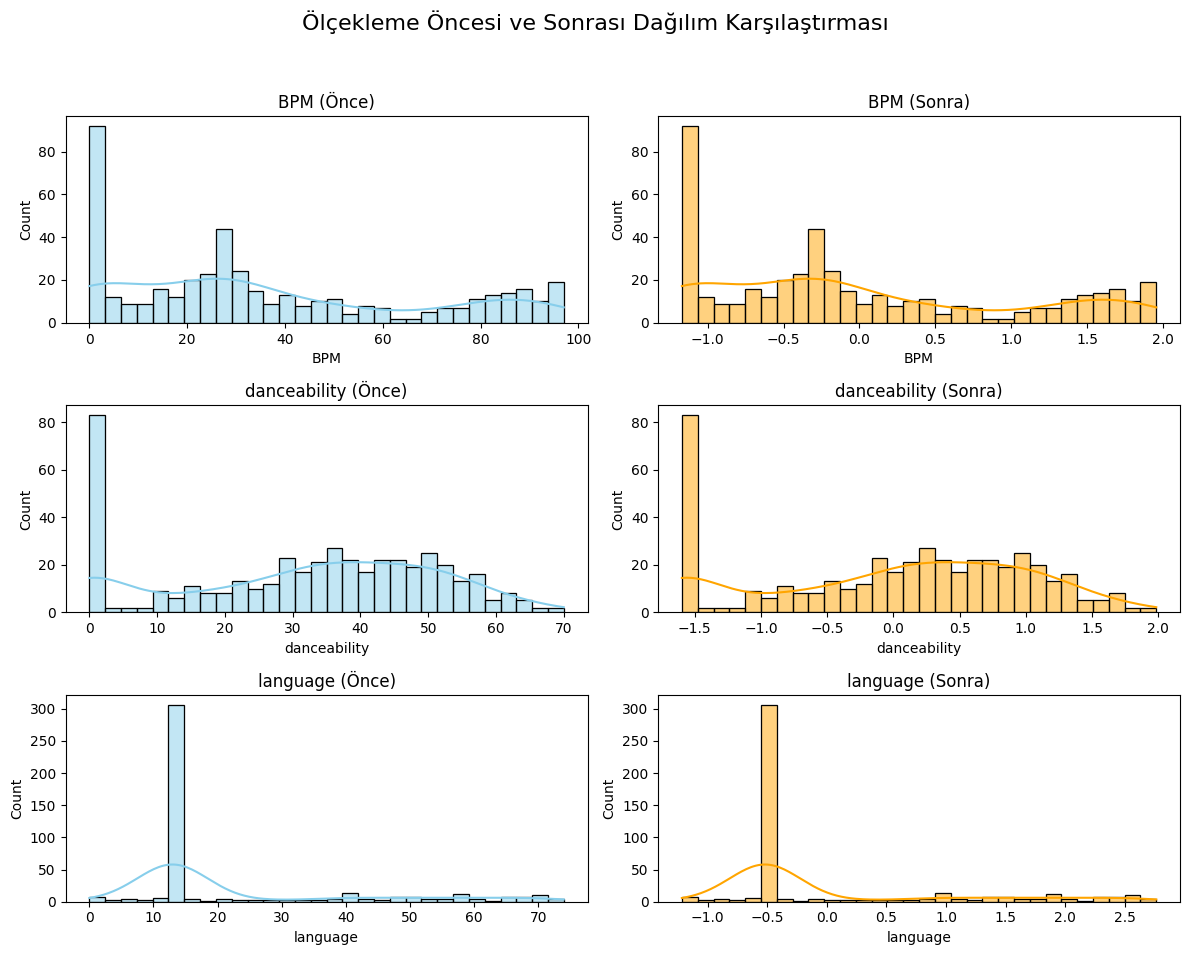

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# özellik ve hedef değişkeni ayırır
X = df.drop(columns=["top10"])
y = df["top10"]

# eğitim ve test verilerini ayırır (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standart scaler ile ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ölçekleme öncesi ve sonrası için dataframeler
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# karşılaştırılacak sütunlar
cols_to_compare = ['BPM', 'danceability', 'language']

# görselleştirme
fig, axes = plt.subplots(len(cols_to_compare), 2, figsize=(12, 10))
fig.suptitle("Ölçekleme Öncesi ve Sonrası Dağılım Karşılaştırması", fontsize=16)

for i, col in enumerate(cols_to_compare):
    # ölçekleme öncesi
    sns.histplot(X_train_df[col], bins=30, ax=axes[i, 0], kde=True, color='skyblue')
    axes[i, 0].set_title(f"{col} (Önce)")
    
    # ölçekleme sonrası
    sns.histplot(X_train_scaled_df[col], bins=30, ax=axes[i, 1], kde=True, color='orange')
    axes[i, 1].set_title(f"{col} (Sonra)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("olcekleme_karsilastirma.png")


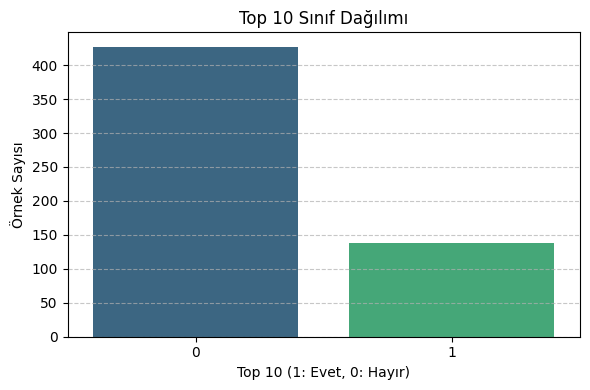

In [9]:
# hedef değişkenin (top10) dağılımını görüntüleme
import seaborn as sns

target_counts = df['top10'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette="viridis", legend=False)
plt.title("Top 10 Sınıf Dağılımı")
plt.xlabel("Top 10 (1: Evet, 0: Hayır)")
plt.ylabel("Örnek Sayısı")
plt.xticks([0, 1])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig("top10_dagilim_karsilastirma.png")

In [10]:
# sınıf dengesizliğini gidermek için : SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "10" 

# SMOTE ile dengeleme
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Sınıf dağılımı kontrolü
print("Sınıf dağılımı (önce):", Counter(y_train))
print("Sınıf dağılımı (SMOTE sonra):", Counter(y_train_resampled))


Sınıf dağılımı (önce): Counter({0: 349, 1: 103})
Sınıf dağılımı (SMOTE sonra): Counter({1: 349, 0: 349})


## Modelleme Aşaması

Kullanılacak ML Algoritmaları:
- Logistic Regression
- Random Forest
- XGBoost

In [12]:
# logistic regression modelinin geliştirilmesi

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# modelin oluşturulması
log_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)

# tahmin 
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]


In [13]:
# random forest modelinin geliştirilmesi

from sklearn.ensemble import RandomForestClassifier

# modelin oluşturulması
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# tahmin
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]


In [14]:
# xgboost modelinin geliştirilmesi

from xgboost import XGBClassifier

# modelin oluşturulması
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# tahmin
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]


In [15]:
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

# tüm  başarı metriklerini liste halinde tut
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba_log),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
}

# DataFrame oluştur
results_df = pd.DataFrame(results)

# F1 Score'a göre sırala
results_df = results_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

# Sonuçları yazdır
print("Model Performans Karşılaştırması (F1 Score'a Göre Sıralı):")
display(results_df)


Model Performans Karşılaştırması (F1 Score'a Göre Sıralı):


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.637168,0.455882,0.885714,0.601942,0.718681
1,XGBoost,0.610619,0.384615,0.428571,0.405405,0.694505
2,Random Forest,0.619469,0.382353,0.371429,0.376812,0.695421


## Model İyileştirme

In [17]:
# logistic regression — grid search

from sklearn.model_selection import GridSearchCV

# LogisticRegression model ve parametre aralığı
lr = LogisticRegression(max_iter=1000, random_state=42)
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# GridSearchCV tanımlaması
grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Eğitim
grid_lr.fit(X_train_resampled, y_train_resampled)

# En iyi parametreler
best_lr = grid_lr.best_estimator_
print("En iyi Logistic Regression parametreleri:", grid_lr.best_params_)

# Tahmin
y_pred_lr = best_lr.predict(X_test_scaled)
y_proba_lr = best_lr.predict_proba(X_test_scaled)[:, 1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
En iyi Logistic Regression parametreleri: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [18]:
# random forest — gridsearch

from sklearn.ensemble import RandomForestClassifier

# Random Forest model ve parametre aralığı
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV ile optimizasyon
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# En iyi parametreler
print("En iyi Random Forest parametreleri:", grid_search_rf.best_params_)

# Model performansını değerlendirme
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
En iyi Random Forest parametreleri: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [19]:
# xgboost — gridsearch

from xgboost import XGBClassifier

# XGBoost model ve parametre aralığı
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}

# GridSearchCV ile optimizasyon
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# En iyi parametreler
print("En iyi XGBoost parametreleri:", grid_search_xgb.best_params_)

# Model performansını değerlendirme
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]


Fitting 5 folds for each of 162 candidates, totalling 810 fits
En iyi XGBoost parametreleri: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


In [20]:
# tüm  başarı metriklerini liste halinde tut
results2 = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
}

# DataFrame oluştur
results2_df = pd.DataFrame(results2)

# F1 Score'a göre sırala
results2_df = results2_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

# Sonuçları yazdır
print("Model Performans Karşılaştırması (F1 Score'a Göre Sıralı):")
display(results2_df)


Model Performans Karşılaştırması (F1 Score'a Göre Sıralı):


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.601770,0.432432,0.914286,0.587156,0.715018
1,Random Forest,0.628319,0.387097,0.342857,0.363636,0.689194
2,XGBoost,0.592920,0.342857,0.342857,0.342857,0.682784


Recursive Feature Elimination (RFE) Kullanarak Özellik Seçimi

In [22]:
# logistic regression için rfe

from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score

# RFE ile en iyi 10 özelliği seç
selector_rfe = RFE(best_lr, n_features_to_select=10)
X_train_rfe = selector_rfe.fit_transform(X_train_resampled, y_train_resampled)
X_test_rfe = selector_rfe.transform(X_test_scaled)

# Modeli eğit
best_lr.fit(X_train_rfe, y_train_resampled)

# Modeli değerlendir
y_pred_rfe = best_lr.predict(X_test_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe)
print(f'F1 Skoru (RFE ile seçilen özelliklerle): {f1_rfe}')


F1 Skoru (RFE ile seçilen özelliklerle): 0.5871559633027523


In [23]:
# random forest için rfe

# RFE ile en iyi 10 özelliği seç
selector_rfe = RFE(best_rf, n_features_to_select=10)
X_train_rfe = selector_rfe.fit_transform(X_train_resampled, y_train_resampled)
X_test_rfe = selector_rfe.transform(X_test_scaled)  

# Modeli eğit
best_rf.fit(X_train_rfe, y_train_resampled)

# Modeli değerlendir
y_pred_rfe = best_rf.predict(X_test_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe)
print(f'F1 Skoru (RFE ile seçilen özelliklerle): {f1_rfe}')


F1 Skoru (RFE ile seçilen özelliklerle): 0.3880597014925373


In [24]:
# xgboost için rfe 

# RFE ile en iyi 10 özelliği seç
selector_rfe = RFE(best_xgb, n_features_to_select=10)
X_train_rfe = selector_rfe.fit_transform(X_train_resampled, y_train_resampled)
X_test_rfe = selector_rfe.transform(X_test_scaled) 

# Modeli eğit
best_xgb.fit(X_train_rfe, y_train_resampled)

# Modeli değerlendir
y_pred_rfe = best_xgb.predict(X_test_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe)
print(f'F1 Skoru (RFE ile seçilen özelliklerle): {f1_rfe}')


F1 Skoru (RFE ile seçilen özelliklerle): 0.3939393939393939


C:\Users\zny26\AppData\Local\Temp\ipykernel_8476\4182285934.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_importance_df, palette="magma")


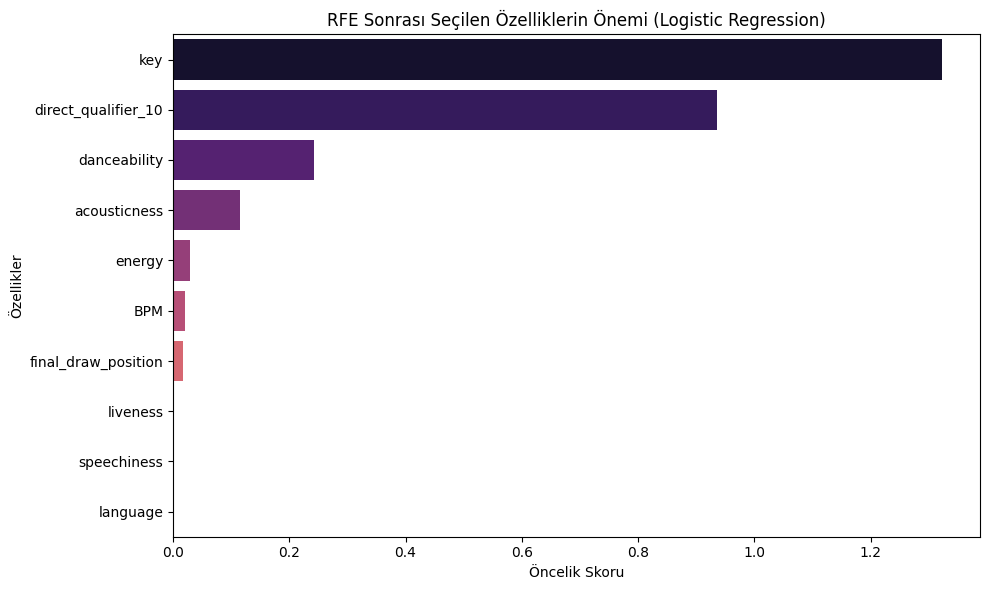

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
# import pandas as pd
X_res_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# 1. Seçilen özelliklerin isimleri
selected_feature_names = X_res_df.columns[selector_rfe.support_]

# 2. Logistic Regression için katsayıları al
# Not: coef_ bir 2D array'dir -> (1, n_features)
coefficients = best_lr.coef_.flatten()

# 3. DataFrame oluştur
feat_importance_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Importance": np.abs(coefficients)  # mutlak değer önem skoru gibi kullanılabilir
}).sort_values(by="Importance", ascending=False)

# 4. Görselleştir
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_importance_df, palette="magma")
plt.title("RFE Sonrası Seçilen Özelliklerin Önemi (Logistic Regression)")
plt.xlabel("Öncelik Skoru")
plt.ylabel("Özellikler")
plt.tight_layout()
plt.savefig("lr_best.png")




In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Model isimlerini ve modelleri sakla
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

# Sonuçları tutmak için liste
results = []

for name, model in models.items():
    # RFE ile özellik seçimi
    selector_rfe = RFE(model, n_features_to_select=10)
    X_train_rfe = selector_rfe.fit_transform(X_train_resampled, y_train_resampled)
    X_test_rfe = selector_rfe.transform(X_test_scaled)

    # Model eğitimi
    model.fit(X_train_rfe, y_train_resampled)

    # Tahmin
    y_pred = model.predict(X_test_rfe)
    y_proba = model.predict_proba(X_test_rfe)[:, 1]  # ROC AUC için

    # Metrikleri hesapla
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Sonuçları kaydet
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })

# Tabloyu oluştur
results_df = pd.DataFrame(results)

# Sonuçları yazdır
results_df


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.601770,0.432432,0.914286,0.587156,0.715018
1,Random Forest,0.637168,0.406250,0.371429,0.388060,0.676190
2,XGBoost,0.646018,0.419355,0.371429,0.393939,0.705861


In [27]:
# cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# En iyi modeller (GridSearch sonrası elde edilen en iyi modeller)
best_models = {
    'Logistic Regression': best_lr,
    'XGBoost': best_xgb,
    'Random Forest': best_rf
}

# Cross-Validation Değerlendirmesi
cv_results = {}

# Cross-Validation uygulama
for model_name, model in best_models.items():
    # Cross-Validation skorları (F1 Score)
    cv_score = cross_val_score(model, X_train_rfe, y_train_resampled, cv=5, scoring='f1')
    cv_results[model_name] = cv_score
    print(f"{model_name} - Cross-Validation F1 Scores: {cv_score}")
    print(f"{model_name} - Mean F1 Score: {np.mean(cv_score)}\n")

# Cross-Validation sonuçlarını karşılaştırmak
cv_comparison = pd.DataFrame(cv_results)
cv_comparison['Mean F1 Score'] = cv_comparison.mean(axis=1)
cv_comparison = cv_comparison.sort_values(by='Mean F1 Score', ascending=False)

print("Cross-Validation Performans Karşılaştırması (F1 Score):")
cv_comparison


Logistic Regression - Cross-Validation F1 Scores: [0.74666667 0.70967742 0.74390244 0.7875     0.72151899]
Logistic Regression - Mean F1 Score: 0.7418531024775336

XGBoost - Cross-Validation F1 Scores: [0.70769231 0.81632653 0.86451613 0.90789474 0.87837838]
XGBoost - Mean F1 Score: 0.8349616165114588

Random Forest - Cross-Validation F1 Scores: [0.66129032 0.7862069  0.86451613 0.90789474 0.88590604]
Random Forest - Mean F1 Score: 0.8211628250550378

Cross-Validation Performans Karşılaştırması (F1 Score):


,Logistic Regression,XGBoost,Random Forest,Mean F1 Score
3,0.787500,0.907895,0.907895,0.867763
4,0.721519,0.878378,0.885906,0.828601
2,0.743902,0.864516,0.864516,0.824312
1,0.709677,0.816327,0.786207,0.770737
0,0.746667,0.707692,0.661290,0.705216


In [28]:
# Cross-Validation sonuçlarını karşılaştırarak en iyi modeli seçme

cv_comparison = pd.DataFrame(cv_results).T 
cv_comparison['Mean F1 Score'] = cv_comparison.mean(axis=1)
cv_comparison = cv_comparison.sort_values(by='Mean F1 Score', ascending=False)

print("Cross-Validation Performans Karşılaştırması (F1 Score):")
print(cv_comparison)

# En iyi modeli seçme
best_model_name = cv_comparison.index[0] 
best_model = best_models[best_model_name]

print(f"En iyi model: {best_model_name} (F1 Skoru: {cv_comparison.loc[best_model_name, 'Mean F1 Score']:.4f})")


Cross-Validation Performans Karşılaştırması (F1 Score):
                            0         1         2         3         4  \
XGBoost              0.707692  0.816327  0.864516  0.907895  0.878378   
Random Forest        0.661290  0.786207  0.864516  0.907895  0.885906   
Logistic Regression  0.746667  0.709677  0.743902  0.787500  0.721519   

                     Mean F1 Score  
XGBoost                   0.834962  
Random Forest             0.821163  
Logistic Regression       0.741853  
En iyi model: XGBoost (F1 Skoru: 0.8350)


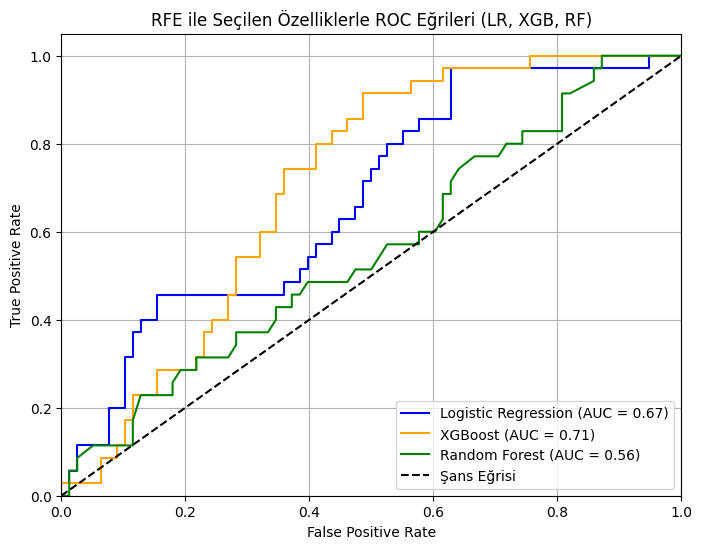

In [29]:
# tüm modeller için ROC eğrisi ve AUC scoreları

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Tahmin olasılıklarını al
y_probs_lr = best_lr.predict_proba(X_test_rfe)[:, 1]
y_probs_xgb = best_xgb.predict_proba(X_test_rfe)[:, 1]
y_probs_rf = best_rf.predict_proba(X_test_rfe)[:, 1]

# ROC eğrisi değerlerini hesapla
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC eğrilerini çiz
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='orange')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Şans Eğrisi')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RFE ile Seçilen Özelliklerle ROC Eğrileri (LR, XGB, RF)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc.png")


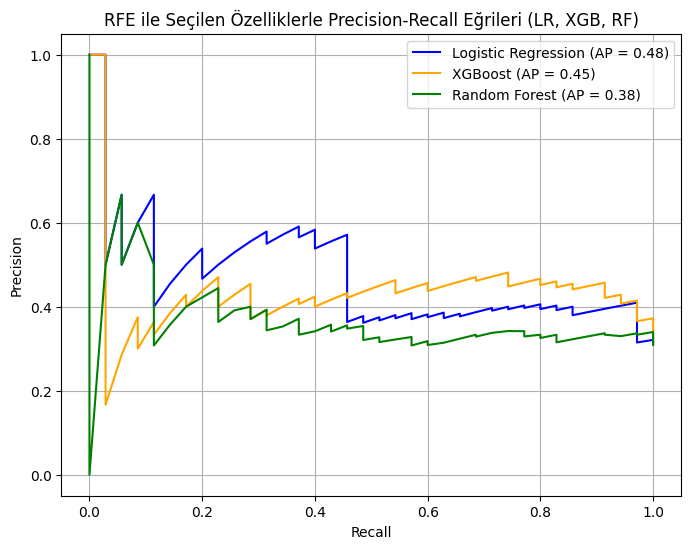

In [30]:
# tüm modeller için precision-recall eğrisi

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Olasılık tahminleri
y_probs_lr = best_lr.predict_proba(X_test_rfe)[:, 1]
y_probs_xgb = best_xgb.predict_proba(X_test_rfe)[:, 1]
y_probs_rf = best_rf.predict_proba(X_test_rfe)[:, 1]

# Precision-Recall eğrisi ve AP skorları
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_probs_lr)
ap_lr = average_precision_score(y_test, y_probs_lr)

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_probs_xgb)
ap_xgb = average_precision_score(y_test, y_probs_xgb)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_probs_rf)
ap_rf = average_precision_score(y_test, y_probs_rf)

# Grafiği çiz
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.2f})', color='blue')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f})', color='orange')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.2f})', color='green')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RFE ile Seçilen Özelliklerle Precision-Recall Eğrileri (LR, XGB, RF)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


## 2024 VERİLERİ İLE TAHMİN YAPTIRMA

Yeni şarkıların Top 10 yapıp yapamayacağını tahmin etmek ve gerçek sonuçla karşılaştırmak

In [32]:
# verilerin bulunduğu excel dosyasını dataframe'e okuma

df_2024 = pd.read_excel('2024_data.xlsx')

In [33]:
df_2024.head()

,year,country,semi_draw_position,final_draw_position,BPM,energy,danceability,happiness,acousticness,liveness,speechiness,style,language,key,direct_qualifier_10,qualified_10,top10
0,2024,Albania,2,-,82,67,61,43,15,46,5,Pop,English,G Major,0,0,0
1,2024,Armenia,8,19,133,74,43,58,16,32,7,Traditional,Armenian,G Major,0,1,1
2,2024,Australia,13,-,110,87,69,82,5,7,7,Traditional,"English, Yankunytjatjara",C Minor,0,0,0
3,2024,Austria,6,26,140,91,58,26,1,8,6,Dance,English,Ab Major,0,1,0
4,2024,Azerbaijan,12,-,96,84,44,9,1,31,6,Pop,"English, Azerbaijani",G Minor,0,0,0


In [34]:
# 2024 verisindeki kategorik sütunları belirle
categorical_columns_2024 = df_2024.select_dtypes(include="object").columns.tolist()

# Kategorik sütunlardaki eksik verileri doldurma
for col in categorical_columns_2024:
    df_2024[col] = df_2024[col].fillna('Unknown')

# Daha önceki encoder'lar (label_encoders) ile dönüştürme
for col in categorical_columns_2024:
    if col in label_encoders:
        le = label_encoders[col]
        # Eğitim verisinde olmayan kategori varsa 'Unknown' olarak işaretle
        df_2024[col] = df_2024[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
        le_classes = le.classes_.tolist()
        if 'Unknown' not in le_classes:
            le_classes.append('Unknown')
            le.classes_ = np.array(le_classes)
        df_2024[col] = le.transform(df_2024[col].astype(str))
    else:
        print(f"Uyarı: {col} sütunu eğitim verisinde yoktu, encode edilemiyor.")


In [35]:
df_2024.head()

,year,country,semi_draw_position,final_draw_position,BPM,energy,danceability,happiness,acousticness,liveness,speechiness,style,language,key,direct_qualifier_10,qualified_10,top10
0,2024,0,20,0,82,67,61,43,15,46,5,3,13,25,0,0,0
1,2024,2,20,28,133,74,43,58,16,32,7,5,2,25,0,1,1
2,2024,3,20,0,110,87,69,82,5,7,7,5,75,10,0,0,0
3,2024,4,20,28,140,91,58,26,1,8,6,1,13,3,0,1,0
4,2024,5,20,0,96,84,44,9,1,31,6,3,75,26,0,0,0


In [36]:
# kod ölçekleme ve özellik seçimi
y_2024 = df_2024["top10"]
X_2024 = df_2024.drop(columns=["top10"])

# Ölçekleme (eğitimde kullanılan scaler ile)
X_2024_scaled = scaler.transform(df_2024.drop(columns=["top10"]))  # 'top10' modelin tahmin edeceği sütun

# Özellik seçimi (eğitimde kullanılan RFE seçici ile)
X_2024_rfe = selector_rfe.transform(X_2024_scaled)



In [37]:
# yeni veri setindeki ülkelerin top 10 tahmini yapıyor ve gerçek sonuçlarla karşılaştırıyor

# Olasılıkları al
y_2024_proba = best_xgb.predict_proba(X_2024_rfe)[:, 1]

# En yüksek olasılığa sahip ilk 10 ülkenin indeksleri
top10_indices = np.argsort(y_2024_proba)[-10:]

# Tahmin etiketlerini oluştur
y_2024_top10_based = np.zeros_like(y_2024_proba, dtype=int)
y_2024_top10_based[top10_indices] = 1  # Sadece en yüksek 10'a 1 ver

# Tahmin ve gerçek sonuçları yazıya çevir
prediction_labels = ["Evet" if pred == 1 else "Hayır" for pred in y_2024_top10_based]
actual_labels = ["Evet" if actual == 1 else "Hayır" for actual in y_2024]

country_names = label_encoders["country"].inverse_transform(df_2024["country"])

# Sonuçları DataFrame olarak göster
results_df_top10 = pd.DataFrame({
    "Ülke": country_names,
    "Tahmin (Top 10)": prediction_labels,
    "Gerçek Sonuç": actual_labels,
    "Olasılık": y_2024_proba.round(4)
}).sort_values(by="Olasılık", ascending=False)

# Görüntüle
results_df_top10


,Ülke,Tahmin (Top 10),Gerçek Sonuç,Olasılık
36,United Kingdom,Evet,Hayır,0.9883
14,Germany,Evet,Hayır,0.9838
17,Ireland,Evet,Evet,0.9619
7,Cyprus,Evet,Hayır,0.9521
1,Armenia,Evet,Evet,0.9109
19,Italy,Evet,Evet,0.8698
15,Greece,Evet,Hayır,0.8395
12,France,Evet,Evet,0.7454
20,Latvia,Evet,Hayır,0.6143
33,Sweden,Evet,Evet,0.6065


In [38]:
from sklearn.metrics import classification_report

# Sınıflandırma raporunu yazdır
print("Classification Report (Top 10'a girecek en iyi 10 ülke varsayımıyla):\n")
print(classification_report(y_2024, y_2024_top10_based, target_names=["Hayır", "Evet"]))


Classification Report (Top 10'a girecek en iyi 10 ülke varsayımıyla):

              precision    recall  f1-score   support

       Hayır       0.81      0.81      0.81        27
        Evet       0.50      0.50      0.50        10

    accuracy                           0.73        37
   macro avg       0.66      0.66      0.66        37
weighted avg       0.73      0.73      0.73        37



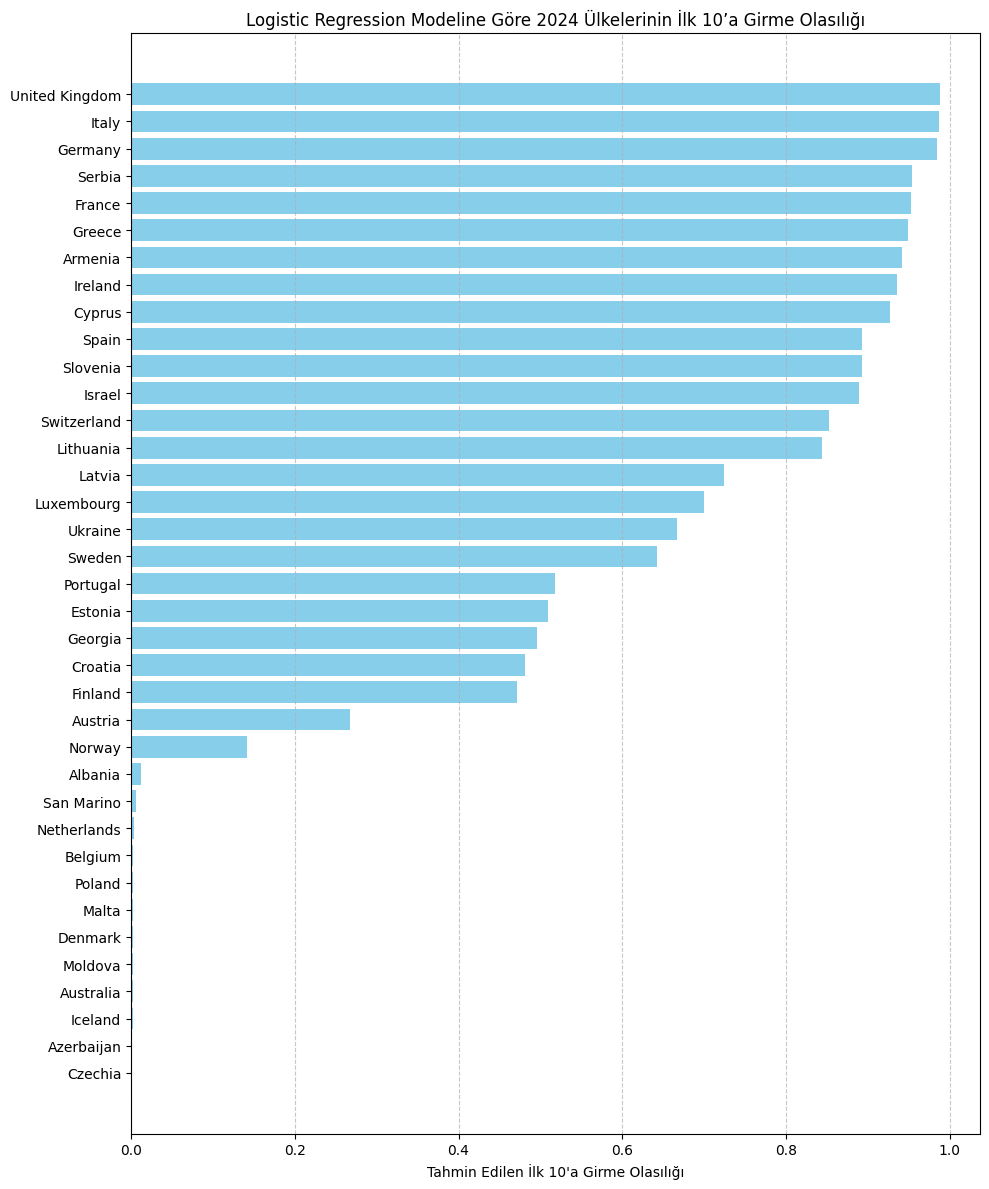

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Verileri manuel olarak oluştur (sıralı)
data = {
    "Ülke": ["United Kingdom", "Italy", "Germany", "Serbia", "France", "Greece", "Armenia", "Ireland", "Cyprus", "Spain",
             "Slovenia", "Israel", "Switzerland", "Lithuania", "Latvia", "Luxembourg", "Ukraine", "Sweden", "Portugal",
             "Estonia", "Georgia", "Croatia", "Finland", "Austria", "Norway", "Albania", "San Marino", "Netherlands",
             "Belgium", "Poland", "Malta", "Denmark", "Moldova", "Australia", "Iceland", "Azerbaijan", "Czechia"],
    "Olasılık": [0.9876, 0.9875, 0.9846, 0.9545, 0.9521, 0.9485, 0.9415, 0.9356, 0.9269, 0.8934,
                 0.8926, 0.8888, 0.8528, 0.8435, 0.7246, 0.6997, 0.6663, 0.6423, 0.5184, 0.5091,
                 0.4958, 0.4807, 0.4709, 0.2673, 0.1418, 0.0122, 0.0054, 0.0034, 0.0028, 0.0027,
                 0.0025, 0.0025, 0.0025, 0.0024, 0.0018, 0.0008, 0.0006]
}

# DataFrame oluştur ve sırala
df = pd.DataFrame(data)
df_sorted = df.sort_values(by="Olasılık", ascending=True)

# Grafik oluştur
plt.figure(figsize=(10, 12))
plt.barh(df_sorted["Ülke"], df_sorted["Olasılık"], color="skyblue")
plt.xlabel("Tahmin Edilen İlk 10'a Girme Olasılığı")
plt.title("Logistic Regression Modeline Göre 2024 Ülkelerinin İlk 10’a Girme Olasılığı")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("ilk10.png")